###Planet NDVI Time Series

In [82]:
#! pip install geopandas

In [83]:
#! pip install geemap

In [ ]:
#! pip install rasterio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import re
import rasterio
from rasterio.mask import mask
import pandas as pd
import warnings
import ee
import geemap
import datetime
import json
import pyproj
from shapely.ops import transform
import pyproj
from shapely.ops import transform as shapely_transform

In [2]:
def calculate_ndvi(red_band, nir_band):
    numerator = nir_band - red_band
    denominator = nir_band + red_band

    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where((denominator == 0) & (numerator == 0), np.nan, numerator / denominator)

    return ndvi

In [3]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [4]:
# Define the path to AOI GeoJSON file
aoi_file = '/content/AoI_site4_test3_rp.geojson'
directory = '/content/gdrive/MyDrive/Clip'

In [5]:
# Read the AOI GeoJSON file using GeoPandas
aoi = gpd.read_file(aoi_file)

In [6]:
# Initialize empty lists to store the dates and NDVI values
dates = []
ndvi_values_planet = []

# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".tif"):
        # Extract the date from the filename using regular expressions
        match = re.search(r"\d{4}-\d{2}", filename)  # Assuming the date is in the format YYYY-MM
        if match:
            date_str = match.group()
            date = pd.to_datetime(date_str, format='%Y-%m')

            # Read the red and near-infrared bands from the image
            with rasterio.open(os.path.join(directory, filename)) as src:
                red_band = src.read(1)
                nir_band = src.read(2)

                # Clip the bands to the AOI boundaries
                clipped_image, transform = mask(src, aoi.geometry, crop=True)

            # Calculate NDVI
            try:
                denominator = clipped_image[1] + clipped_image[0]
                numerator = clipped_image[1] - clipped_image[0]
                ndvi = calculate_ndvi(clipped_image[0], clipped_image[1])
                ndvi_values_planet.append(np.nanmean(ndvi))  # Taking the mean NDVI value for the image
                dates.append(date)
            except Exception as e:
                print(f"Error calculating NDVI for {date_str}: {str(e)}")



In [7]:
# Convert the lists to numpy arrays
dates = np.array(dates)
ndvi_values_planet = np.array(ndvi_values_planet)

In [8]:
# Sort the arrays by date
sorted_indices = np.argsort(dates)
dates = dates[sorted_indices]
ndvi_values_planet = ndvi_values_planet[sorted_indices]

In [9]:
# Create a DataFrame for Planet data
planet_df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values_planet})

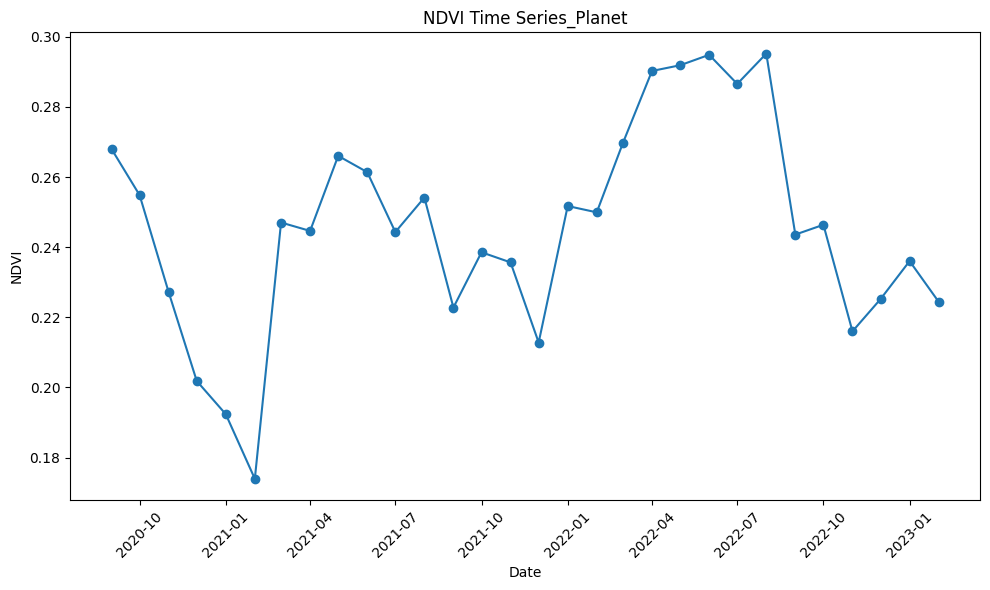

In [10]:
# Plot the NDVI time series
plt.figure(figsize=(10, 6))
plt.plot(dates, ndvi_values_planet, marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series_Planet')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.show()

##Sentinel 2 NDVI Time Series

In [11]:
# Initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=tWL8dPDsJF-6l7g7NnULHm9BmRCJfLigi4eAVlkAYFg&tc=Vb17t2pGT2mfBKH178xJ2kYrw8yJfAbqI4xQ-XHRwbM&cc=p-KSMWbhubL4ngg2jFHaECzy76JCmrBPtD5F4Rxo3Hs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VMh3cZfWuLEWkAmT6aA-ZU1bOh6LzWllS3q-cXurBJ873-gw7NisHw

Successfully saved authorization token.


In [12]:
# Read the GeoJSON file
with open('/content/AoI_site4_test3_rp.geojson') as file:
    geojson_data = json.load(file)

# Validate the GeoJSON geometry
if 'features' in geojson_data and len(geojson_data['features']) > 0:
    geometry = geojson_data['features'][0].get('geometry')
    if geometry is not None:
        print("GeoJSON geometry is valid.")
    else:
        print("GeoJSON geometry is invalid.")
else:
    print("No valid features found in GeoJSON.")


GeoJSON geometry is valid.


In [13]:
# Read the AOI GeoJSON file using GeoPandas
aoi = gpd.read_file('/content/AoI_site4_test3_rp.geojson')

# Extract the geometry from the GeoDataFrame
aoi_geometry = aoi.geometry.values[0]

In [14]:
# Specify the target projection
target_projection = 'EPSG:4326'  # Change to the desired projection

# Define the transformation function using pyproj
transformer = pyproj.Transformer.from_crs(aoi.crs, target_projection, always_xy=True).transform

# Reproject the geometry using shapely.ops.transform
aoi_geometry_reprojected = shapely_transform(transformer, aoi_geometry)

# Create an EE Geometry object from the reprojected geometry
ee_aoi_geometry = ee.Geometry.Polygon(list(aoi_geometry_reprojected.exterior.coords))

In [15]:
# Define the timeframe
start_date = '2020-10-01'
end_date = '2023-01-31'

In [16]:
# Function to calculate NDVI
def calculate_ndvi(image):
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI').set('system:time_start', image.get('system:time_start'))


# Fetch Sentinel-2 data for the AOI and timeframe
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(ee_aoi_geometry).filterDate(start_date, end_date)

# Add NDVI band to the images
ndvi_collection = sentinel2.map(calculate_ndvi)

# Extract NDVI values for the AOI
def get_ndvi_values(image):
    image_id = image.get('system:id')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    ndvi = image.reduceRegion(ee.Reducer.mean(), ee_aoi_geometry, 10).get('NDVI')
    return ee.Feature(None, {'date': date, 'ndvi': ndvi, 'value': ndvi, 'image_id': image_id})  # Add 'image_id' parameter

ndvi_features = ndvi_collection.map(get_ndvi_values).getInfo()['features']



In [17]:
# Create a DataFrame to store the dates and NDVI values
dates = []
ndvi_values_S2 = []

for feature in ndvi_features:
    properties = feature['properties']
    date = pd.to_datetime(properties['date'])
    ndvi = properties['ndvi']
    if ndvi is not None:
        dates.append(date)
        ndvi_values_S2.append(ndvi)

In [18]:
# Create a DataFrame with dates and NDVI values
sentinel_df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values_S2})

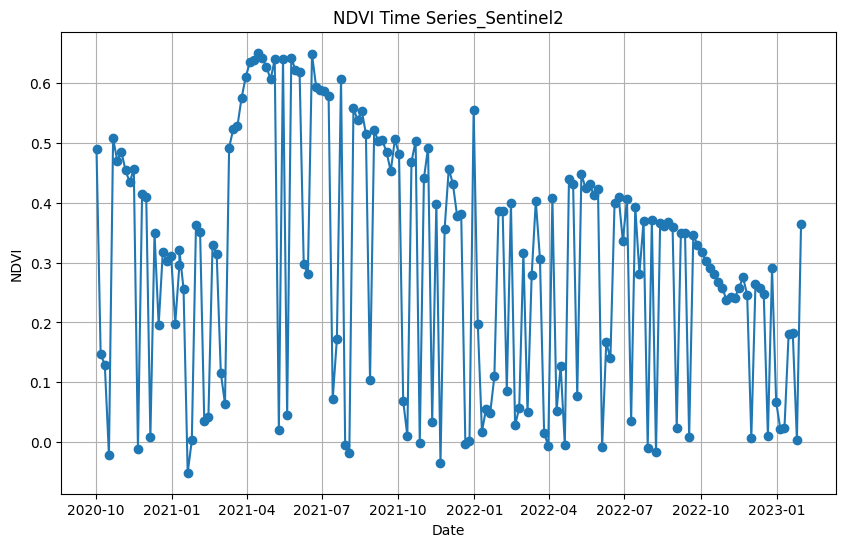

In [19]:
# Plot the NDVI time series
plt.figure(figsize=(10, 6))
plt.plot(sentinel_df['Date'], sentinel_df['NDVI'], marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series_Sentinel2')
plt.grid(True)
plt.show()

###Planet + Sentinel2 NDVI Time Series

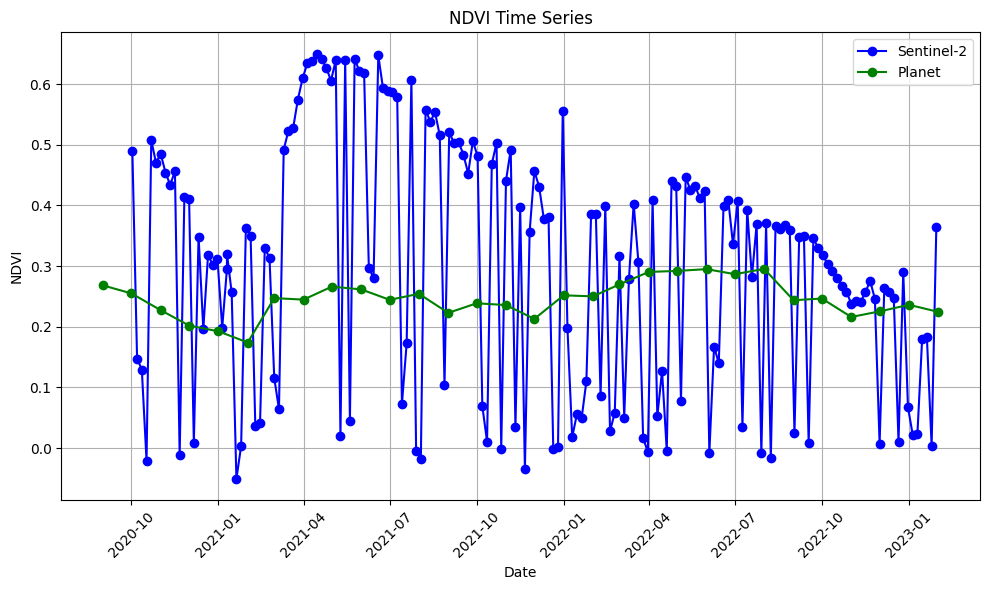

In [22]:
# Plot the Sentinel-2 NDVI time series
plt.figure(figsize=(10, 6))
plt.plot(sentinel_df['Date'], sentinel_df['NDVI'], marker='o', color='blue', label='Sentinel-2')

# Plot the Planet NDVI time series
plt.plot(planet_df['Date'], planet_df['NDVI'], marker='o', color='green', label='Planet')

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
